variational parameter を dict型に格納
計算時間が大きいので、この方針はやめておく.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.tri as tri
import edward as ed
import numpy as np
import tensorflow as tf
from edward.models import Categorical, MultivariateNormalDiag, Dirichlet, OneHotCategorical, MultivariateNormalFullCovariance
from functools import reduce
import time
import distributions
from build_dataset import build_dataset_2dim_Kclass_gmm
from visualize_tools import circle, ellipse, covariance_ellipse, change_aspect_ratio

In [4]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
plt.style.use('ggplot')

In [5]:
N = 100
K = 3
mean_true = [[-1.0,-1.0], [-1.0,6.0] , [2.0,5.0]]
covariance_true = [[[1.0,0.0],[0.0,1.0]],
       [[2.0,0.5],[0.5,1.5]],
       [[1.8,-0.2],[-0.2,2.5]]]
mix_true  = np.array([ 0.2 , 0.4, 0.4 ])
x_data, label,mix = build_dataset_2dim_Kclass_gmm(N,K,mean_true,covariance_true,mix_true)

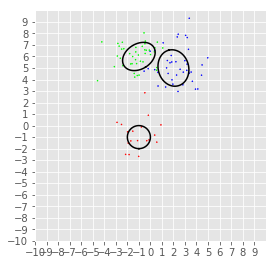

In [6]:
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(-10.0,10.0)
ax.set_ylim(-10.0,10.0)
plt.xticks( np.arange(-10.0, 10.0, 1.0) )
plt.yticks( np.arange(-10.0, 10.0, 1.0) )
plt.gca().set_aspect('equal', adjustable='box')
for k in range(K):
    c1,c2,ca=covariance_ellipse(covariance_true[k])
    ex,ey=ellipse(c1,c2,ca)
    plt.plot(ex+mean_true[k][0],ey+mean_true[k][1],color="black")
    #plt.plot(ex*2+mean_true[k][0],ey*2+mean_true[k][1],color="green")
    #plt.plot(ex*3+mean_true[k][0],ey*3+mean_true[k][1],color="green")
color=["#FF0000","#00FF00","#0000FF"]
area = [[1.0]*N]
for n,x in enumerate(x_data):
    plt.scatter(x[0],x[1],s = area, color=color[label[n]])
plt.show()

In [41]:
def gmm_bbvi_z_pi(N,mu,cov,x_data,n_iter):
    start = time.time()

    mu = tf.constant(mu, dtype = tf.float32)
    sigma = tf.constant(cov, dtype = tf.float32)

    #generative model 
    alpha = tf.constant([1.0, 1.0, 1.0])
    pi = Dirichlet(concentration = alpha)
    z = [OneHotCategorical(probs = pi, dtype = tf.float32) for n in range(N)]
    x = [MultivariateNormalFullCovariance(loc = sum([mu[k]*z[n][k] for k in range(K)]),covariance_matrix = sum([sigma[k]*z[n][k] for k in range(K)])) for n in range(N)]
    print("generative model")
    #variational model
    lambda_pi = tf.nn.softplus(tf.Variable([0.0 , 0.0 , 0.0]))
    qpi = Dirichlet(concentration = lambda_pi)
    y = [tf.Variable([0.0,0.0,0.0], dtype = tf.float32) for n in range(N)]
    lambda_z = [tf.nn.softmax(y[n]) for n in range(N)]
    qz = [OneHotCategorical(probs = lambda_z[n], dtype = tf.float32) for n in range(N)]
    print("variational model")
    latent_vars = {z[n]:qz[n] for n in range(N)}
    latent_vars[pi] = qpi
    
    x_ph =  [tf.placeholder(tf.float32,[2]) for n in range(N)]
    #data = {x[n]:x_data[n] for n in range(N)}
    data = {x[n]:x_ph[n] for n in range(N)}
    inference = ed.KLqp(latent_vars=latent_vars,data=data)
    inference.initialize(n_iter=n_iter)
    print("inference")
    print(time.time()-start)
    sess = ed.get_session()
    tf.global_variables_initializer().run()
    loss =[]
    variational_parameter=[]
    #variational_parameter.append(sess.run([lambda_pi,lambda_z]))
    tmp = sess.run([lambda_pi,lambda_z])
    print(tmp)
    vp = {"lambda_pi" : tmp[0], "lambda_z" : tmp[1]}
    variational_parameter.append(vp)
    for _ in range(inference.n_iter):
        info_dict = inference.update(feed_dict = {x_ph[n]:x_data[n] for n in range(N)})
        loss.append(info_dict['loss'])
        #variational_parameter.append(sess.run([lambda_pi,lambda_z]))
        tmp = sess.run([lambda_pi,lambda_z])
        vp = {"lambda_pi" : tmp[0], "lambda_z" : tmp[1]}
        variational_parameter.append(vp)
    print(time.time()-start)
    return loss,variational_parameter                             
                                 

In [42]:
loss,variational_parameter = gmm_bbvi_z_pi(N,mean_true,covariance_true,x_data,5)

generative model
variational model
inference
114.88207197189331
[array([ 0.69314718,  0.69314718,  0.69314718], dtype=float32), [array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype=float32), array([ 0.33333334,  0.33333334,  0.33333334], dtype

In [46]:
for t,vp in enumerate(variational_parameter):
    print(t,vp.get('lambda_pi'))

0 [ 0.69314718  0.69314718  0.69314718]
1 [ 0.64439666  0.64439666  0.74439669]
2 [ 0.63097358  0.60008985  0.72797453]
3 [ 0.65625125  0.56288159  0.75735676]
4 [ 0.68022209  0.52935654  0.77630723]
5 [ 0.69363165  0.51065755  0.78559005]


<IPython.core.display.Javascript object>


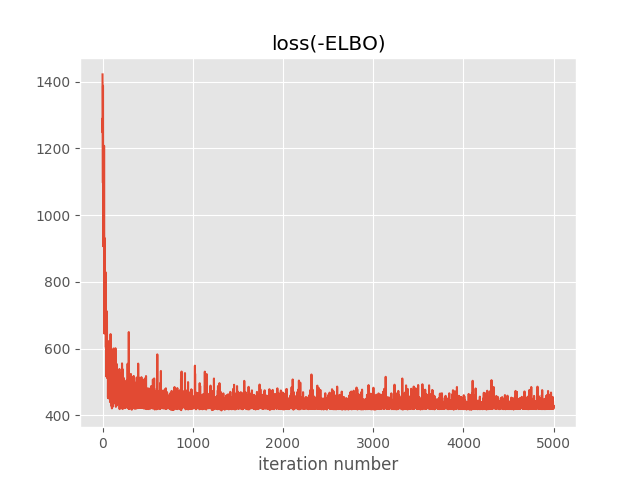

In [11]:
%matplotlib nbagg
plt.title("loss(-ELBO)")
plt.plot(loss)
plt.xlabel("iteration number")
plt.show()

<IPython.core.display.Javascript object>


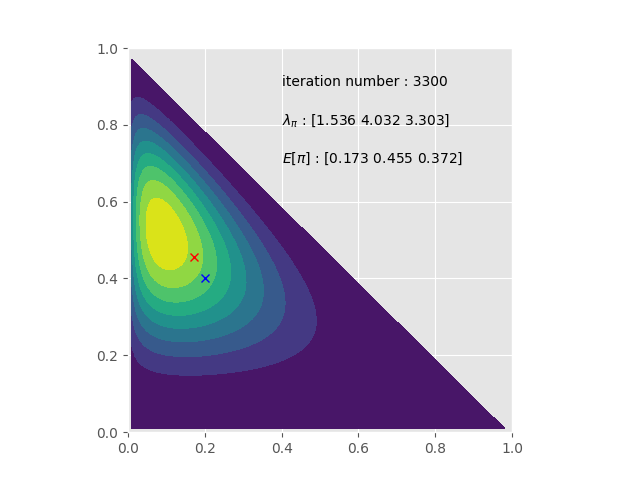

In [12]:
%matplotlib nbagg
import scipy.stats as ss
import matplotlib.tri as mtri
from matplotlib import cm
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(0.0,1.0)
ax.set_ylim(0.0,1.0)
plt.gca().set_aspect('equal', adjustable='box')
X = []
Y = []

for x in np.arange(0.01,0.99,0.01):
    for y in  np.arange(0.01,0.99-x,0.01):
        X.append(x)
        Y.append(y)
triang = mtri.Triangulation(X, Y)

plt.plot(mix_true[0],mix_true[1],"bx")
artists = []
for t,vp in enumerate(variational_parameter):
    if t %100 == 0:
        dc = ss.dirichlet(np.array(vp[0]))
        
        Z = []
        for x,y in zip(X,Y):
            Z.append(dc.pdf((x,y)))

        sum_pi = vp[0][0]+vp[0][1]+vp[0][2]
        exp = vp[0]/sum_pi
            
        text = [plt.text(0.4,0.9,"iteration number : "+str(t)),
                    plt.text(0.4,0.8,"$\lambda_\pi$ : ["+"{0:.3f}".format(vp[0][0]) + " {0:.3f}".format(vp[0][1]) + " {0:.3f}]".format(vp[0][2])),
                    plt.text(0.4,0.7,"$E[\pi]$ : ["+"{0:.3f}".format(exp[0]) + " {0:.3f}".format(exp[1]) + " {0:.3f}]".format(exp[2]))]

        im_pi = ax.tricontourf(triang, Z,10)
        

        e = plt.plot(exp[0],exp[1],"rx")
        
        artists.append(im_pi.collections+text+e)
ani=animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("gmm_2dim_3class_pi.gif", writer='imagemagick', fps=4)

<IPython.core.display.Javascript object>


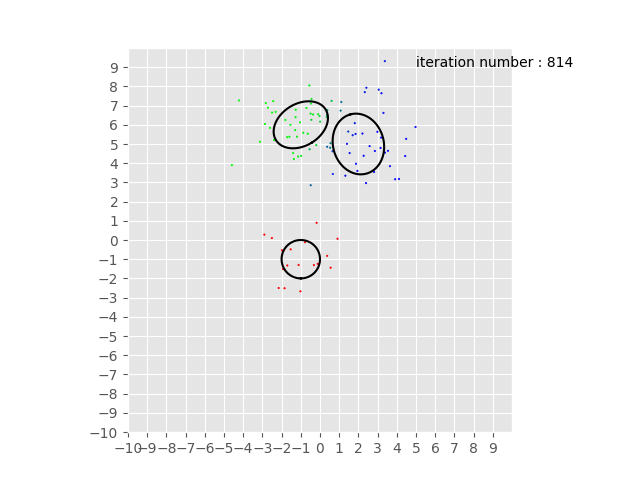

In [13]:
%matplotlib nbagg
fig = plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8])
ax.set_xlim(-10.0,10.0)
ax.set_ylim(-10.0,10.0)
plt.xticks( np.arange(-10.0, 10.0, 1.0) )
plt.yticks( np.arange(-10.0, 10.0, 1.0) )
plt.gca().set_aspect('equal', adjustable='box')
for k in range(K):
    c1,c2,ca=covariance_ellipse(covariance_true[k])
    ex,ey=ellipse(c1,c2,ca)
    plt.plot(ex+mean_true[k][0],ey+mean_true[k][1],color="black")
artists = []
area = [[1.0]*N]
for t,vp in enumerate(variational_parameter):
    text = [plt.text(5.0,9.0,"iteration number : "+str(t))]
    im_z=plt.scatter(x_data.T[0],x_data.T[1],s=area,color=vp[1])
    artists.append([im_z]+text)
ani=animation.ArtistAnimation(fig,artists)
plt.show()
#ani.save("gmm_2dim_3class_z.gif", writer='imagemagick', fps=4)